# Задание 1.

Имеется файл (ссылка на гугл диск: https://drive.google.com/file/d/1bDynbu7oHkL3HQ5ql0e9nHZP_Dg_3xVY/view?usp=sharing) с временной статистикой работы асессоров (асессор – человек, выполняющий оценочную работу «оценщик») над однотипным заданием.

Формат файла: login tid Microtasks assigned_ts tclosed_ts.

Пояснение к формату: login — логин асессора; tid — id оцениваемого задания (task id); Microtasks – количество микрозаданий в одном задании; assigned_ts — время резервирования системой задания для асессора; closed_ts — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? 

Опишите подробно все этапы вашего решения.


## Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


plt.rcParams['figure.figsize'] = (18,8)

In [2]:
PATH = 'C:\\Users\\Илья\\Downloads\\'

## 1.1  Загружаем данные

In [3]:
data = pd.read_csv(PATH + 'data_task4_old.txt', 
                   sep='\t', 
                   parse_dates=['assigned_ts', 'closed_ts'])

In [4]:
data.head()

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   login        701827 non-null  object        
 1   tid          701827 non-null  float64       
 2   Microtasks   701827 non-null  float64       
 3   assigned_ts  701827 non-null  datetime64[ns]
 4   closed_ts    701827 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 26.8+ MB


In [6]:
data['tid'] = data['tid'].astype('int32')
data['Microtasks'] = data['Microtasks'].astype('int32')

In [7]:
data.isnull().sum()

login          0
tid            0
Microtasks     0
assigned_ts    0
closed_ts      0
dtype: int64

In [8]:
data.describe()

,tid,Microtasks
count,7.018270e+05,701827.00000
mean,1.884911e+08,3.25439
std,1.391113e+07,3.65397
min,1.139586e+08,1.00000
25%,1.906846e+08,1.00000
50%,1.935373e+08,2.00000
75%,1.963667e+08,4.00000
max,1.985758e+08,50.00000


In [ ]:
# Микрозадачи варьируются от 1 до 50. В половине всех задач по 2 микрозадачи.

In [153]:
# # Посмотрим уникальные логины
# data.groupby('login')['tid'].nunique().sort_values(ascending=False)

## Анализируем данные

In [9]:
payment_period = 30

### Рассчитываем разницу между временем выдачи и завершения задания в сек

In [10]:
data['timedelta_sec'] = (data['closed_ts'] - data['assigned_ts']).dt.total_seconds()

###  Рассчитываем время на выполнение 1 минизадачи

In [11]:
data['timedelta_on_one_microtask'] = data['timedelta_sec'] / data['Microtasks']

### Рассчитываем сколько в среднем пользователь тратит на выполнение 1 минизадачи

In [12]:
avg_sec_on_task = (
    data.groupby(['login'], as_index=False)
    .agg({'timedelta_on_one_microtask': (lambda x: x.mean())})
    .rename(columns={'timedelta_on_one_microtask': 'mean_sec_on_task'})
)
avg_sec_on_task

,login,mean_sec_on_task
0,login0,881.508394
1,login1,142.951907
2,login10,1256.049121
3,login100,150.688690
4,login101,197.868935
...,...,...
762,login95,115.208974
763,login96,51.017959
764,login97,2442.516316
765,login98,2459.748568


### Отсeчем выбросы по квантилям 

In [13]:
quantile_025  = avg_sec_on_task.mean_sec_on_task.quantile(0.025)
quantile_0975 = avg_sec_on_task.mean_sec_on_task.quantile(0.975)

### Оставим данные без выбросов

In [17]:
salary_assessors = (
    avg_sec_on_task[avg_sec_on_task['mean_sec_on_task']
                    .between(quantile_025, 
                             quantile_0975, 
                             inclusive='neither')])

### Рассчитываем возможную стоимость оплаты 1 микрозадачи

In [18]:
salary_assessors = salary_assessors['mean_sec_on_task'].mean() / payment_period

In [19]:
print(f'Возможная стоимость оплаты 1 микрозадачи = {salary_assessors}*N')

Возможная стоимость оплаты 1 микрозадачи = 29.760781277419742*N


In [111]:
# Посмотрим сколько в среденем выполняется одна микрозадача

In [145]:
mean_time_on_task = (
    data
    .groupby(['tid'], as_index=False)
    .agg({'timedelta_on_one_microtask': 'mean'})
    .rename(columns={'timedelta_on_one_microtask':'mean_sec_on_task'})
)

In [146]:
# Добавим средние значения в основной датасет
data = pd.merge(data, mean_time_on_task, how='left', on='tid')

In [147]:
data

,login,tid,Microtasks,assigned_ts,closed_ts,timedelta_sec,timedelta_on_one_microtask,mean_sec_on_task
0,login0,190563850,4,2017-04-20 12:09:39,2017-04-20 13:13:01,3802.0,950.500000,950.500000
1,login0,190561754,1,2017-04-20 12:10:30,2017-04-20 12:28:29,1079.0,1079.000000,1079.000000
2,login0,190565906,4,2017-04-20 12:21:31,2017-04-20 13:30:10,4119.0,1029.750000,1029.750000
3,login0,190560246,1,2017-04-20 12:28:30,2017-04-20 13:13:56,2726.0,2726.000000,2726.000000
4,login0,190562168,2,2017-04-20 12:28:42,2017-04-20 13:14:50,2768.0,1384.000000,1384.000000
...,...,...,...,...,...,...,...,...
701822,login766,195656026,1,2017-05-15 15:53:27,2017-05-15 16:16:56,1409.0,1409.000000,986.750000
701823,login766,195656174,1,2017-05-15 15:53:33,2017-05-15 16:21:53,1700.0,1700.000000,918.250000
701824,login766,195656466,1,2017-05-15 15:53:38,2017-05-15 16:23:41,1803.0,1803.000000,2371.400000
701825,login766,195656336,3,2017-05-15 15:54:18,2017-05-15 16:32:11,2273.0,757.666667,757.666667


In [ ]:
# 

In [148]:
data.query('login == "login766"')
# Видно, что у пользователя есть расхождения между временем, которое затратил пользователь и среднем временем на выполнение этого задания.
# Если бы мы отсчитывали точное время начала выполнения работы, то с помощью среднего на выполнения задания мы могли бы устанавливать диффернциальную оплату по ассессорам

,login,tid,Microtasks,assigned_ts,closed_ts,timedelta_sec,timedelta_on_one_microtask,mean_sec_on_task
701724,login766,190477854,3,2017-04-20 12:03:44,2017-04-20 13:09:20,3936.0,1312.000000,452.333333
701725,login766,189961804,1,2017-04-21 04:20:49,2017-04-21 04:30:32,583.0,583.000000,353.400000
701726,login766,190745968,1,2017-04-21 04:30:18,2017-04-21 04:36:41,383.0,383.000000,172.800000
701727,login766,190745910,1,2017-04-21 04:30:33,2017-04-21 04:37:22,409.0,409.000000,195.000000
701728,login766,190553444,1,2017-04-21 04:36:43,2017-04-21 04:40:04,201.0,201.000000,201.000000
...,...,...,...,...,...,...,...,...
701822,login766,195656026,1,2017-05-15 15:53:27,2017-05-15 16:16:56,1409.0,1409.000000,986.750000
701823,login766,195656174,1,2017-05-15 15:53:33,2017-05-15 16:21:53,1700.0,1700.000000,918.250000
701824,login766,195656466,1,2017-05-15 15:53:38,2017-05-15 16:23:41,1803.0,1803.000000,2371.400000
701825,login766,195656336,3,2017-05-15 15:54:18,2017-05-15 16:32:11,2273.0,757.666667,757.666667


# Задание 2.

Имеется файл (ссылка на гугл диск: https://drive.google.com/file/d/1d3TA49Mh7hL-VSWAvT74AGSpAmTfGyK6/view?usp=sharing) с различными оценками асессоров  (асессор – человек, выполняющий оценочную работу «оценщик»).

Формат файла: login tuid docid jud cjud.

Пояснение к формату: login — логин асессора; uid — id асессора (user id); docid — id оцениваемого документа (document id); jud — оценка асессора (judgement); cjud — правильная оценка (correct judgement); разделитель — табуляция \t.

Оценки могут принимать значение [0, 1], т.е. задание, которое сделали асессоры, имеет бинарную шкалу.

Используя данные об оценках, установите, какие асессоры хуже всего справились с заданием. На какие показатели вы ориентировались и какие метрики вы использовали для ответа на этот вопрос? Можно ли предложить какие-то новые метрики для подсчета качества асессоров с учетом природы оценок у этого бинарного задания?

Опишите подробно все этапы вашего решения.


## Загружаем данные

In [15]:
data_2 = pd.read_csv(PATH + 'data_task3.csv', 
                     sep='\t')

In [16]:
data_2.head()

,login,uid,docid,jud,cjud
0,assessor158,158,0,0,0
1,assessor238,238,0,0,0
2,assessor488,488,0,0,0
3,assessor136,136,0,0,0
4,assessor300,300,0,0,0


### Смотрим общую информацию по объектам

In [17]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   login   250000 non-null  object
 1   uid     250000 non-null  int64 
 2   docid   250000 non-null  int64 
 3   jud     250000 non-null  int64 
 4   cjud    250000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [18]:
# Проверям наличие нулевых значений
data_2.isnull().sum()

login    0
uid      0
docid    0
jud      0
cjud     0
dtype: int64

In [19]:
# Смотрим основные статистики датасета
data_2.describe()

,uid,docid,jud,cjud
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,299.325672,24999.500000,0.238120,0.119920
std,173.131872,14433.785594,0.425934,0.324869
min,0.000000,0.000000,0.000000,0.000000
25%,150.000000,12499.750000,0.000000,0.000000
50%,299.000000,24999.500000,0.000000,0.000000
75%,449.000000,37499.250000,0.000000,0.000000
max,599.000000,49999.000000,1.000000,1.000000


## Анализ датасета

Основной метрикой измерения качества работ ассессоров будет **accuracy** - доля правльных ответов. Но эта метрика в задачах не очень полезна в задачах с неравными классами.   
В качестве дополнительной метрики используем **f1-меру** - среднее гармоническое точности и полноты, т.к она помогает найти оптимальный баланс между этими 2-мя метриками (с помощью поиска оптимального порога (threshold)).  
В свою очередь **Precision** можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а **recall** доля объектов положительного класса из всех объектов положительного класса. 

Для расчета метрик напишем функцию. 

In [20]:
def get_metrics(df):
    
    """
    Функция принимает на вход датасет и по нему рассчитывает
    метрики - accuracy и f-меру 
    """
    
    assessors = []
    f1        = []
    accuracy  = []
    
    for assessor in df['login'].unique():
           
        y_true = df['cjud'][df['login'] == assessor]
        y_pred = df['jud'][df['login']  == assessor]

        assessors.append(assessor)
        f1.append(f1_score(y_true, y_pred))
        accuracy.append(accuracy_score(y_true, y_pred))
   
    return pd.DataFrame({'assessors': assessors, 
                        'f1_score': f1, 
                        'accuracy': accuracy
                        })    

In [21]:
metrics_df = get_metrics(data_2)

In [22]:
metrics_df.head()

,assessors,f1_score,accuracy
0,assessor158,0.587156,0.882812
1,assessor238,0.488095,0.800000
2,assessor488,0.496732,0.809877
3,assessor136,0.502732,0.778049
4,assessor300,0.528302,0.821002


# Посмотрим диаграмму распределения значний, чтобы визуально определить выбросы

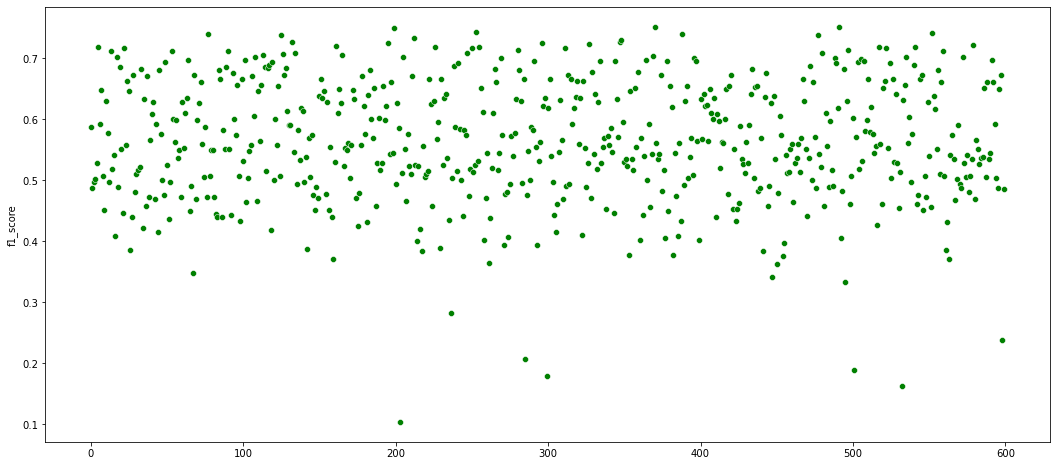

In [24]:
x = [i for i in range(metrics_df['f1_score'].shape[0])]
sns.scatterplot(data=metrics_df, x=x, y='f1_score', color="green");

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


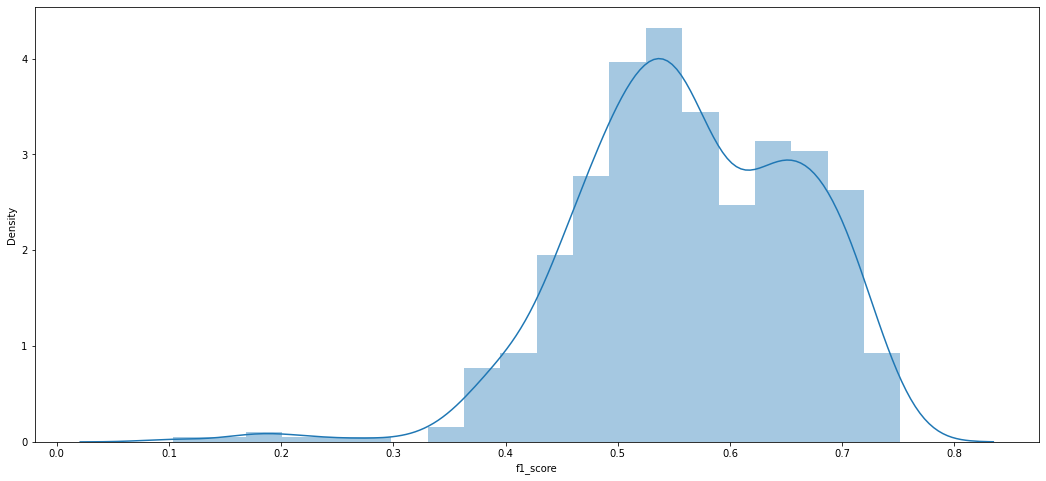

In [135]:
sns.distplot(metrics_df['f1_score']);

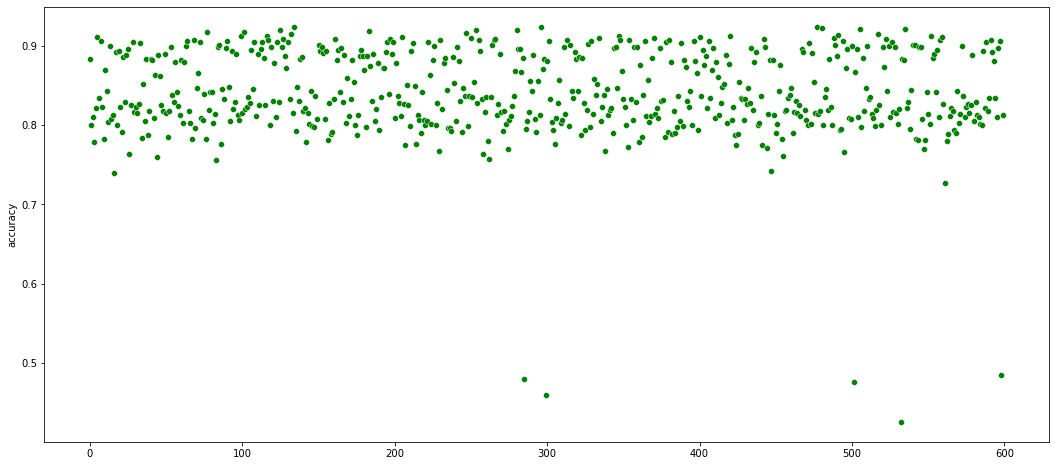

In [136]:
x = [i for i in range(metrics_df['accuracy'].shape[0])]
sns.scatterplot(data=metrics_df, x=x, y='accuracy', color="green");

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


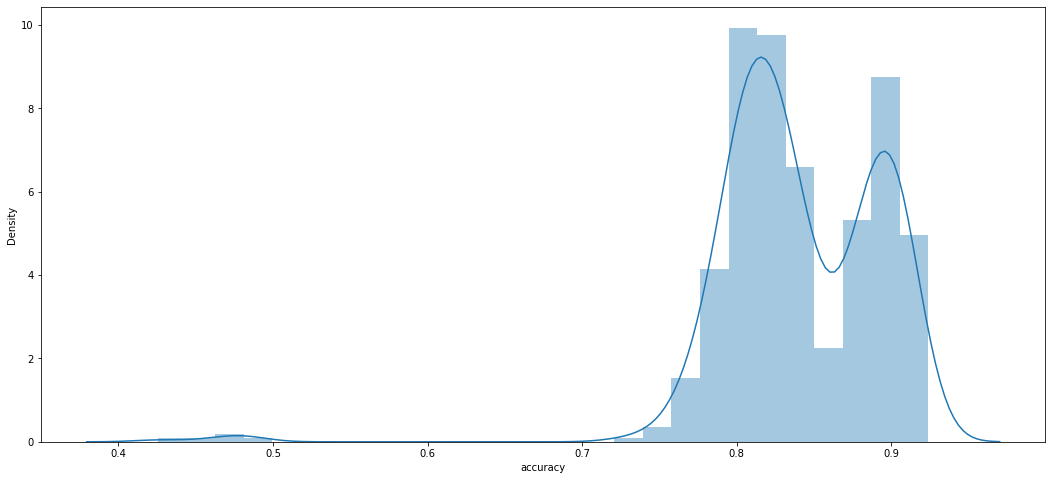

In [137]:
sns.distplot(metrics_df['accuracy']);

Предположим, что хуже всего справляются ассессоры имеющие метрику f1_score<0.5 и  метрику accuracy<0.8

In [138]:
bad_assessors = metrics_df.query('f1_score < 0.5 or accuracy < 0.8')

In [139]:
# Ассессоры хуже всего справившиеся с заданием
bad_assessors

,assessors,f1_score,accuracy
1,assessor238,0.488095,0.800000
2,assessor488,0.496732,0.809877
3,assessor136,0.502732,0.778049
9,assessor295,0.451613,0.782609
12,assessor399,0.497041,0.804147
...,...,...,...
580,assessor96,0.469880,0.804878
585,assessor119,0.537634,0.799534
595,assessor403,0.487179,0.810427
598,assessor234,0.238806,0.484848


In [155]:
print(f'Количество ассессоров хуже всего справившихся с заданием - {bad_assessors.shape[0]}')

Количество ассессоров зуже всего справившихся с заданием - 160
